# Deep Learning Assignment - 5
# Name: Sahana Thoravalli PRabhuswamy
# Github link to assignment

https://github.com/SahanaTP/DeepLearningAssignments



# Loading the fashion MNIST dataset

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

In [ ]:
# import data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11829596.29it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211017.48it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3923212.87it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18423444.53it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



# Different classes in the Fashion MNIST dataset

In [ ]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
img, label = train_set[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Displaying a sample image

Label: 9


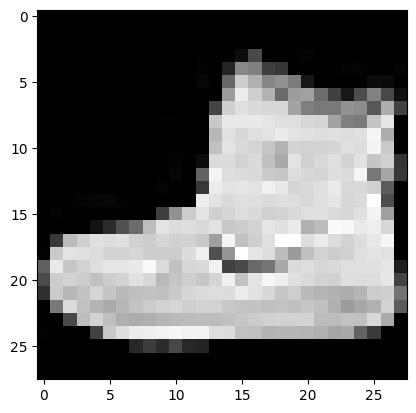

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# using dataloader to load data batchwise

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(train_set, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 0, 3, 8, 4, 8, 2, 9, 8, 3, 9, 3, 3, 1, 8, 4, 2, 0, 0, 7, 1, 6, 2, 8,
        7, 1, 2, 6, 1, 8, 8, 3, 8, 4, 0, 4, 0, 3, 9, 6, 2, 5, 1, 8, 0, 0, 6, 5,
        4, 0, 2, 6, 2, 1, 4, 4, 4, 0, 5, 5, 1, 9, 4, 4, 8, 9, 2, 2, 7, 8, 7, 9,
        6, 1, 4, 1, 6, 2, 9, 2, 2, 3, 7, 5, 0, 3, 1, 5, 8, 4, 5, 7, 5, 9, 9, 9,
        5, 9, 7, 9])


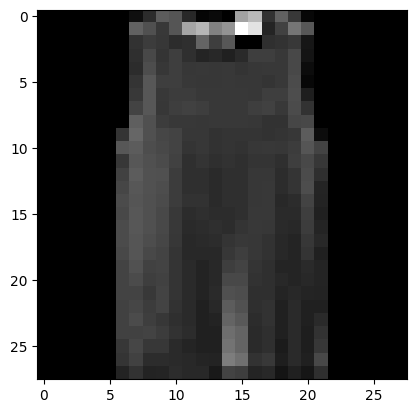

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
image_size = 784
hidden_size = 256

# Defining a Discriminator model

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

In [ ]:
latent_size = 64

# Defining a Generator model

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

# Sample Generator output without training data

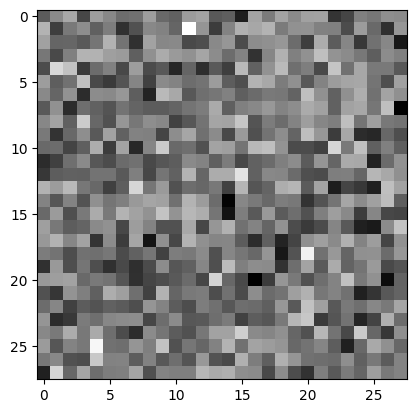

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

In [ ]:
G.to(device);

# Defining loss function and optimizer

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

# Defining a function to train the discrimiator

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

# Defining optimizer of optimizer for generator and a function for training generator

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Displaying sample images for all classes  

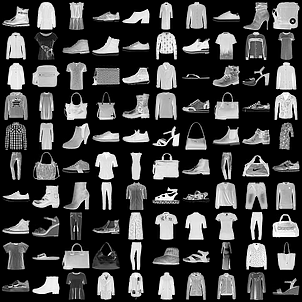

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

# Initial training output or first iteration output of generator

Saving fake_images-0000.png


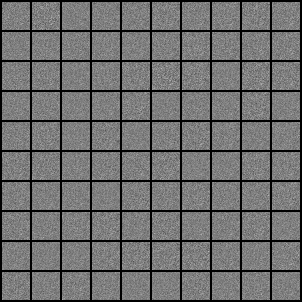

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# Training a discriminator and generator for 300 epochs

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0819, g_loss: 3.9197, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.1140, g_loss: 6.0735, D(x): 0.95, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0201, g_loss: 5.4381, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0337, g_loss: 4.2462, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0635, g_loss: 4.2653, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0248, g_loss: 4.6435, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0580, g_loss: 4.8138, D(x): 0.98, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0669, g_loss: 5.8327, D(x): 0.98, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0645, g_loss: 6.1673, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0552, g_loss: 6.1353, D(x): 0.98, D(G(z)): 0.01
Epoch [3/300], Step [400/6

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

# Displaying a few samples after training after 10, 50, 100 and 300 epochs

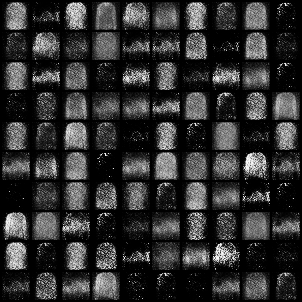

In [ ]:
Image('./samples/fake_images-0010.png')

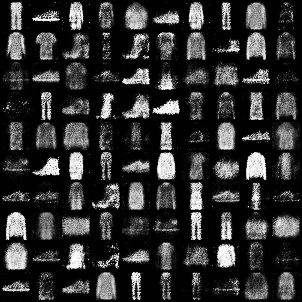

In [ ]:
Image('./samples/fake_images-0050.png')

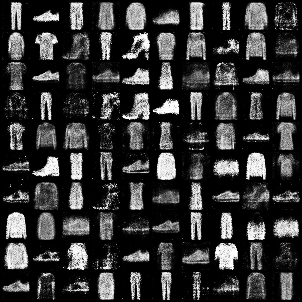

In [ ]:
Image('./samples/fake_images-0100.png')

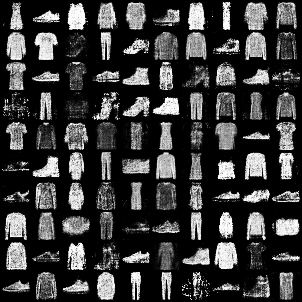

In [ ]:
Image('./samples/fake_images-0300.png')

In [ ]:
import cv2
import os

In [ ]:
img_dir = '/content/samples'

# Saving output images as video

In [ ]:
def create_video_from_images(folder, video_filename):
    #video_filename = 'FashioMNIST_video.mp4'
    valid_images = [i for i in os.listdir(folder) if i.endswith((".jpg", ".jpeg", ".png"))]
    valid_images.sort()
    first_image = cv2.imread(os.path.join(folder, valid_images[0]))
    h, w, _ = first_image.shape

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    vid_writer = cv2.VideoWriter(video_filename, codec, 100, (w, h))

    for img in valid_images:
        loaded_img = cv2.imread(os.path.join(folder, img))
        for _ in range(20):
            vid_writer.write(loaded_img)

    vid_writer.release()

# Create video from resized images
create_video_from_images(img_dir, 'FashioMNIST_video.mp4')

# Plot of loss vs epochs for Discriminator and Generator

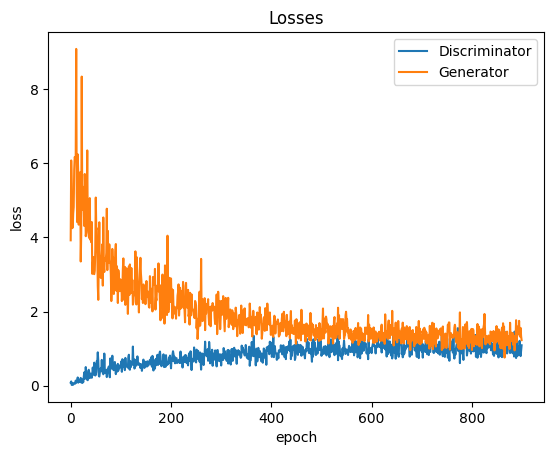

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# Plot of Real Score and fake Score vs epochs

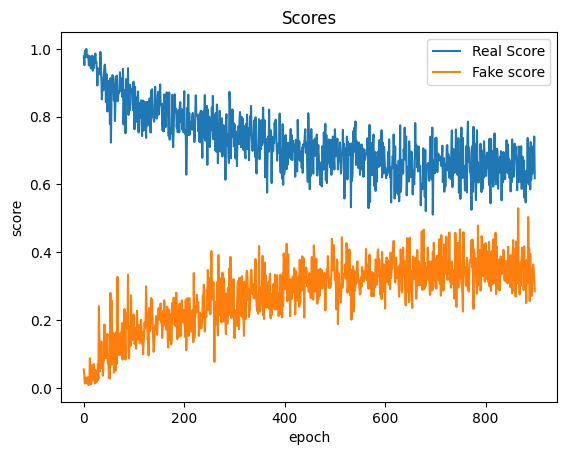

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Difficulties faced during the training process and while saving and reloading the model.



*   It took a long time to train the GAN model
*   The initial images were blurry and later the images became clear


*   Without saving the optimizer state_dict during save model, the model was not giving proper results after re-training.
*   At one point after reloading the model was giving 0 generator loss and 1 discrimator error.





# Saving generator check point model

In [ ]:
PATH = '/content/generator_cp.pth.tar'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': g_loss.item(),
            }, PATH)

# Saving discriminator check point model

In [ ]:
PATH_d = '/content/discriminator_cp.pth.tar'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': d_loss.item(),
            }, PATH_d)

# Defining generator and discrimator models to reload the saved models

In [ ]:
g_model_loaded = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
g_optimizer_loaded = torch.optim.Adam(g_model_loaded.parameters(), lr=0.0002)

In [ ]:
d_loaded = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
d_optmizer_loaded = torch.optim.Adam(d_loaded.parameters(), lr=0.0002)

# Loading generator from check point

In [ ]:
checkpoint = torch.load(PATH)
g_model_loaded.load_state_dict(checkpoint['model_state_dict'])
g_optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Loading discriminator from check point

In [ ]:
checkpoint = torch.load(PATH_d)
d_loaded.load_state_dict(checkpoint['model_state_dict'])
d_optmizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_d = checkpoint['epoch']
loss_d = checkpoint['loss']

In [ ]:
criterion = nn.BCELoss()

In [ ]:
def reset_grad_loaded():
    d_optmizer_loaded.zero_grad()
    g_optimizer_loaded.zero_grad()

def train_discriminator_loaded(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = d_loaded(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = g_model_loaded(z)
    outputs = d_loaded(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optmizer_loaded.step()

    return d_loss, real_score, fake_score

In [ ]:
def train_generator_loaded():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = g_model_loaded(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(d_loaded(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer_loaded.step()
    return g_loss, fake_images

# Re-training the model for 150 epochs to see the improvement in performance

In [ ]:
%%time

num_epochs = 150
total_step = len(data_loader)
#d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(epoch_d, num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator_loaded(images)
        g_loss, fake_images = train_generator_loaded()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [299/350], Step [200/600], d_loss: 1.5066, g_loss: 0.6069, D(x): 0.66, D(G(z)): 0.58
Epoch [299/350], Step [400/600], d_loss: 1.1965, g_loss: 0.7547, D(x): 0.66, D(G(z)): 0.48
Epoch [299/350], Step [600/600], d_loss: 1.1312, g_loss: 0.6920, D(x): 0.69, D(G(z)): 0.49
Saving fake_images-0300.png
Epoch [300/350], Step [200/600], d_loss: 1.2530, g_loss: 0.6418, D(x): 0.65, D(G(z)): 0.52
Epoch [300/350], Step [400/600], d_loss: 1.2477, g_loss: 0.6773, D(x): 0.65, D(G(z)): 0.51
Epoch [300/350], Step [600/600], d_loss: 1.1434, g_loss: 0.7289, D(x): 0.67, D(G(z)): 0.48
Saving fake_images-0301.png
Epoch [301/350], Step [200/600], d_loss: 1.0635, g_loss: 0.7764, D(x): 0.69, D(G(z)): 0.46
Epoch [301/350], Step [400/600], d_loss: 1.1278, g_loss: 0.7547, D(x): 0.67, D(G(z)): 0.47
Epoch [301/350], Step [600/600], d_loss: 1.1861, g_loss: 0.7272, D(x): 0.65, D(G(z)): 0.48
Saving fake_images-0302.png
Epoch [302/350], Step [200/600], d_loss: 1.1902, g_loss: 0.7262, D(x): 0.66, D(G(z)): 0.48
Epoch 

# Sample images after re-training

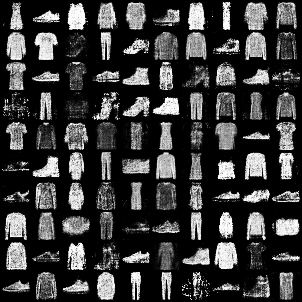

In [ ]:
Image('./samples/fake_images-0301.png')

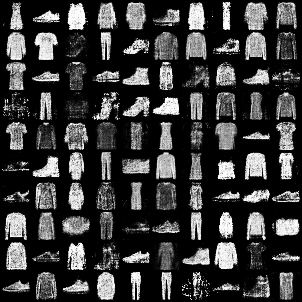

In [ ]:
Image('./samples/fake_images-0310.png')

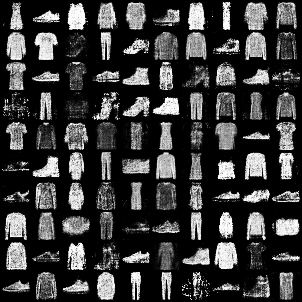

In [ ]:
Image('./samples/fake_images-0325.png')

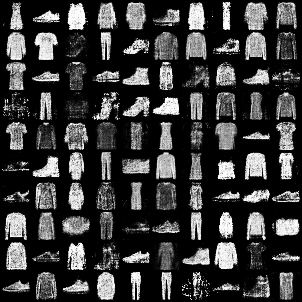

In [ ]:
Image('./samples/fake_images-0340.png')

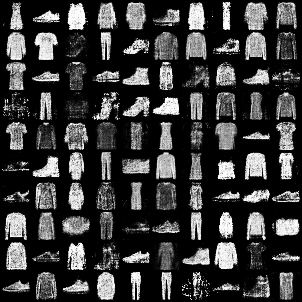

In [ ]:
Image('./samples/fake_images-0350.png')

In [ ]:
create_video_from_images(img_dir, 'FashioMNIST_video_loaded.mp4')

# Plot of loss vs epochs for Generator and Descriminator after re-training, it can be seen that the loss of the Generator has reduced and Discrimator has incresed after re-training, The model has improved it's performance after re-training.

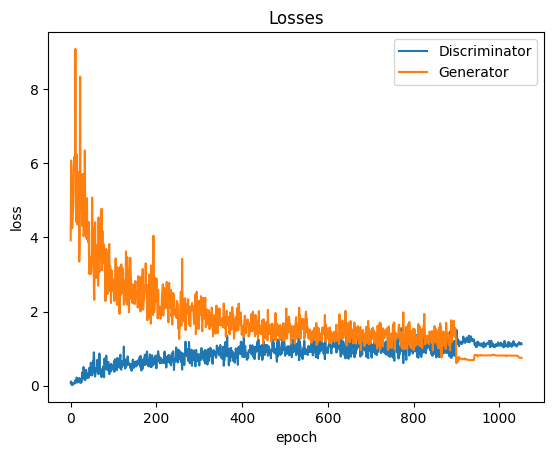

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# Plot of Real scores and Fake scores vs epochs after retraining, the real score has reduced considerable and fake score has improved, this a proof that the model is performing better after re-training.

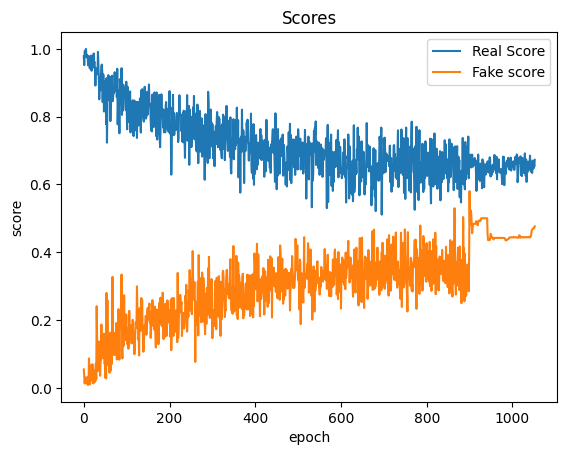

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Saving generated and discriminator model

In [ ]:
PATH_g = '/content/generator_bce.pth'
torch.save(g_model_loaded, PATH_g)
PATH_d = '/content/discriminator_bce.pth'
torch.save(d_loaded, PATH_d)

# LS GAN is a GAN which uses Least square Loss function

In [ ]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

# Training LS GAN for 100 epochs

In [ ]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0270, g_loss: 0.8674, D(x): 0.96, D(G(z)): 0.13
Epoch [0/100], Step [400/600], d_loss: 0.0179, g_loss: 0.9433, D(x): 0.98, D(G(z)): 0.06
Epoch [0/100], Step [600/600], d_loss: 0.0029, g_loss: 0.9518, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.0019, g_loss: 0.9699, D(x): 1.00, D(G(z)): 0.02
Epoch [1/100], Step [400/600], d_loss: 0.0245, g_loss: 0.9612, D(x): 0.96, D(G(z)): 0.03
Epoch [1/100], Step [600/600], d_loss: 0.0063, g_loss: 0.9424, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.0058, g_loss: 0.9818, D(x): 0.99, D(G(z)): 0.01
Epoch [2/100], Step [400/600], d_loss: 0.0011, g_loss: 0.9883, D(x): 1.00, D(G(z)): 0.01
Epoch [2/100], Step [600/600], d_loss: 0.0563, g_loss: 0.9944, D(x): 0.92, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.0373, g_loss: 0.9989, D(x): 0.95, D(G(z)): 0.00
Epoch [3/100], Step [400/6

# Sample images after LSGAN training

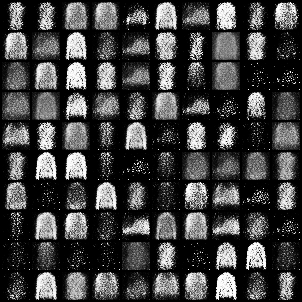

In [ ]:
Image('./samples/fake_images-0010.png')

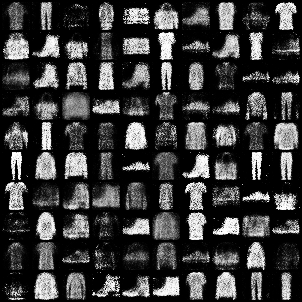

In [ ]:
Image('./samples/fake_images-0050.png')

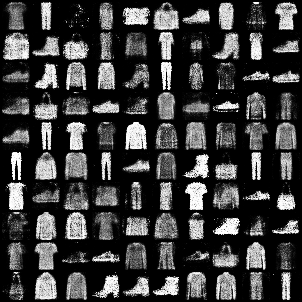

In [ ]:
Image('./samples/fake_images-0100.png')

In [ ]:
img_dir = '/content/samples'
create_video_from_images(img_dir, 'FashioMNIST_video_LSGAN.mp4')

# Plot of Loss vs epochs for LSGAN for forst 100 epochs

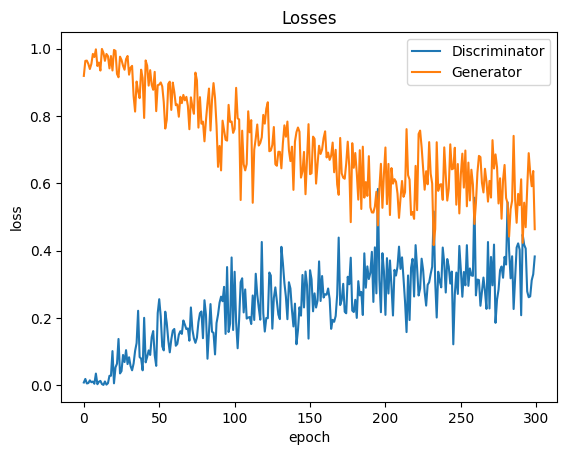

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# Plot of fake and real scores vs epochs for LSGAN after 100 epochs

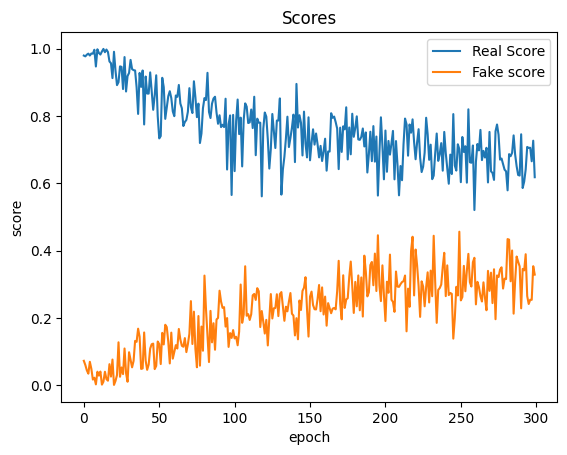

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Saving checkpoint LSGAN model

In [ ]:
PATH = '/content/generator_cp_ls.pth.tar'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': G.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            'loss': g_loss.item(),
            }, PATH)

In [ ]:
PATH_d = '/content/discriminator_cp_ls.pth.tar'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': D.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            'loss': d_loss.item(),
            }, PATH_d)

# Defining Generator and Discriminator model for re-training

In [ ]:
g_model_loaded = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
g_optimizer_loaded = torch.optim.Adam(g_model_loaded.parameters(), lr=0.0001)

In [ ]:
d_loaded = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
d_optmizer_loaded = torch.optim.Adam(d_loaded.parameters(), lr=0.0001)

# Loading LSGAN model for re-training

In [ ]:
checkpoint = torch.load(PATH)
g_model_loaded.load_state_dict(checkpoint['model_state_dict'])
g_optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
checkpoint = torch.load(PATH_d)
d_loaded.load_state_dict(checkpoint['model_state_dict'])
d_optmizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_d = checkpoint['epoch']
loss_d = checkpoint['loss']

In [ ]:
def reset_grad_loaded():
    d_optmizer_loaded.zero_grad()
    g_optimizer_loaded.zero_grad()

def train_discriminator_loaded(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = d_loaded(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = g_model_loaded(z)
    outputs = d_loaded(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optmizer_loaded.step()

    return d_loss, real_score, fake_score

In [ ]:
def train_generator_loaded():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = g_model_loaded(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(d_loaded(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer_loaded.step()
    return g_loss, fake_images

In [ ]:
criterion = nn.MSELoss()

# Re-training LSGAN model for 100 epochs

In [ ]:
%%time

num_epochs = 200
total_step = len(data_loader)
#d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(epoch_d, num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator_loaded(images)
        g_loss, fake_images = train_generator_loaded()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [99/200], Step [200/600], d_loss: 0.2379, g_loss: 0.6346, D(x): 0.72, D(G(z)): 0.25
Epoch [99/200], Step [400/600], d_loss: 0.3024, g_loss: 0.5855, D(x): 0.67, D(G(z)): 0.27
Epoch [99/200], Step [600/600], d_loss: 0.3932, g_loss: 0.4433, D(x): 0.64, D(G(z)): 0.36
Saving fake_images-0100.png
Epoch [100/200], Step [200/600], d_loss: 0.2826, g_loss: 0.6006, D(x): 0.72, D(G(z)): 0.28
Epoch [100/200], Step [400/600], d_loss: 0.4258, g_loss: 0.4765, D(x): 0.61, D(G(z)): 0.38
Epoch [100/200], Step [600/600], d_loss: 0.2508, g_loss: 0.5363, D(x): 0.71, D(G(z)): 0.26
Saving fake_images-0101.png
Epoch [101/200], Step [200/600], d_loss: 0.3155, g_loss: 0.5606, D(x): 0.63, D(G(z)): 0.26
Epoch [101/200], Step [400/600], d_loss: 0.4293, g_loss: 0.3904, D(x): 0.61, D(G(z)): 0.37
Epoch [101/200], Step [600/600], d_loss: 0.4246, g_loss: 0.4404, D(x): 0.59, D(G(z)): 0.33
Saving fake_images-0102.png
Epoch [102/200], Step [200/600], d_loss: 0.3106, g_loss: 0.5303, D(x): 0.67, D(G(z)): 0.28
Epoch [10

# Displaying sample images after re-training LSGAN

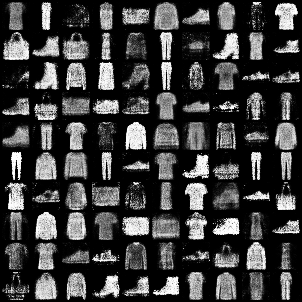

In [ ]:
Image('./samples/fake_images-0125.png')

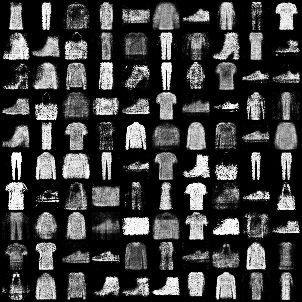

In [ ]:
Image('./samples/fake_images-0150.png')

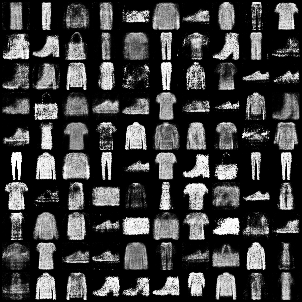

In [ ]:
Image('./samples/fake_images-0175.png')

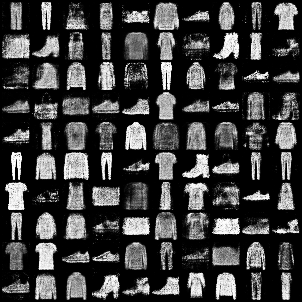

In [ ]:
Image('./samples/fake_images-0200.png')

# Saving LSGAN re-trained model output images as a video file

In [ ]:
img_dir = '/content/samples'
create_video_from_images(img_dir, 'FashioMNIST_video_LSGAN_loaded.mp4')

# Plot of loss vs epochs for Generator and Descriminator after re-training LSGAN, it can be seen that the loss of the Generator has reduced and Discrimator has incresed after re-training, The model has improved it's performance after re-training.

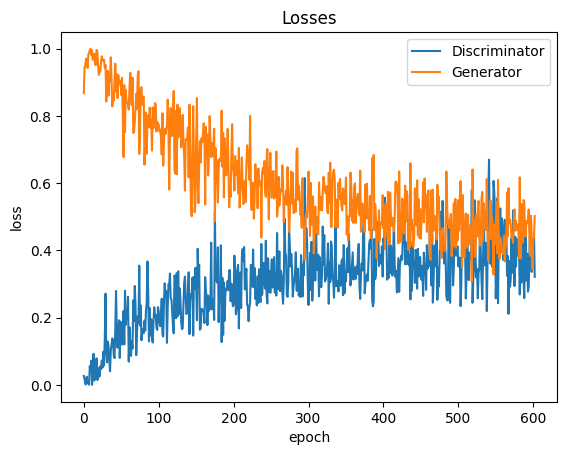

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# Plot of Real scores and Fake scores vs epochs after retraining, the real score has reduced considerable and fake score has improved, this a proof that the LSGAN model is performing better after re-training.

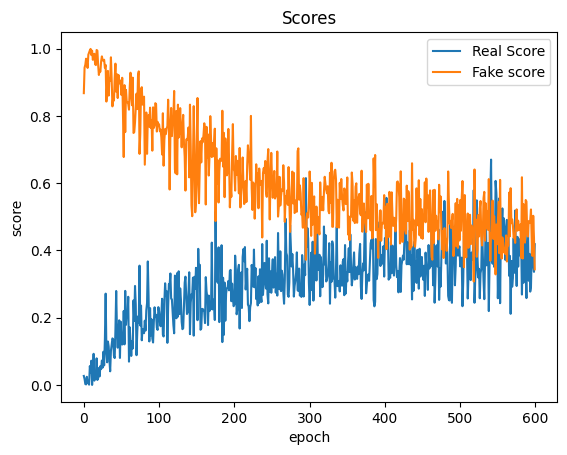

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Saving the LSGAN model without check points

In [ ]:
PATH_g = '/content/generator_ls_reloaded.pth'
torch.save(g_model_loaded, PATH_g)
PATH_d = '/content/discriminator_ls_reloaded.pth'
torch.save(d_loaded, PATH_d)

# GAN vs LSGAN

*   LSGAN is a GAN which uses Least square loss function.
*   LSGANs provide better images in early epochs compared to basic GAN
* LSGANs are more stable in the learning process
* LSGANs have lower loss comapred to basic GAN(for basic GAN the loss range started from 9 whereas for LSGAN the loss range started from 1)

